**Students:** Rami Aridi, Vasilis Skarleas

# Outlook

In this notebook we will study basic reinforcement learning
algorithms: TD learning, Q-learning and SARSA. We will also investigate two
basic exploration strategies: $\epsilon$-greedy and softmax.

## Initialization

We begin by loading all the modules necessary for this notebook.

In [1]:
! pip install easypip
from easypip import easyimport, easyinstall, is_notebook

! pip install swig
! pip install box2d-py
! pip install bbrl_gymnasium
! pip install tensorboard
! pip install moviepy

import sys
import os
import numpy as np
from pathlib import Path
from typing import List, Tuple

if is_notebook() and get_ipython().__class__.__module__ != "google.colab._shell":
   from tqdm.autonotebook import tqdm
else:
   from tqdm.auto import tqdm

import matplotlib.pyplot as plt

if not is_notebook():
    print("Not displaying video (hidden since not in a notebook)", file=sys.stderr)
    def video_display(*args, **kwargs):
        pass
    def display(*args, **kwargs):
        print(*args, **kwargs)

testing_mode = os.environ.get("TESTING_MODE", None) == "ON"

import gymnasium as gym

! pip install bbrl_utils

easyimport("bbrl_utils").setup(maze_mdp=True)
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from mazemdp.mdp import Mdp
from mazemdp.toolbox import egreedy, egreedy_loc, sample_categorical, softmax
from mazemdp import random_policy

/var/folders/t_/frzm_2tj29v28m53gb74jjj00000gn/T/ipykernel_9475/55539437.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Matplotlib backend: module://matplotlib_inline.backend_inline


# Reinforcement Learning

Reinforcement Learning is about finding the optimal policy in an MDP which is
initially unknown to the agent. More precisely, the state and action spaces
are known, but the agent does not know the transition and reward functions.
Generally speaking, the agent has to explore the MDP to figure out which
action in which state leads to which other state and reward. The model-free
case is about finding this optimal policy just through very local updates,
without storing any information about previous interactions with the
environment. Principles of these local updates can already be found in the
Temporal Difference (TD) algorithm, which iteratively computes optimal values
for all state using local updates. The most widely used model-free RL
algorithms are **Q-learning**, **SARSA** and **actor-critic** algorithms.

As for dynamic programming, we first create a maze-like MDP. Reinforcement
learning is slower than dynamic programming, so we will work with smaller
mazes.

In [2]:
import gymnasium as gym

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0, "start_states": [0]},
    render_mode="human",
)
env = env.unwrapped
env.reset()
env.init_draw("The maze")

       [ 1,  4,  7,  8],
       [ 2,  5, -1,  9]]), t…

# Temporal Difference (TD) learning ##

Given a state and an action spaces as well as a policy, TD(0) computes the
state value of this policy based on the following equations:

$$\delta_t = r(s_t,a_t) + \gamma V^{(i)}(s_{t+1})-V^{(i)}(s_t)$$
$$V^{(i+1)}(s_t) = V^{(i)}(s_t) + \alpha\delta_t$$

where $\delta$ is the TD error and $\alpha$ is a parameter called "learning
rate".

The code is provided below, so that you can take inspiration later on. The
important part is the computation of $\delta$, and the update of the values of
$V$.

To run TD learning, a policy is needed as input. Such a policy can be
retreived by using the `policy_iteration_q(mdp)` function defined in the
dynamic programming notebook.

If you want to run this notebook independently, you can use instead the
`random_policy` provided in `mazemdp`. This is what we do here by default,
replace it if you want to run TD learning from an optimal policy.

The ```evaluate``` function below is not necessary for the lab, it is left here for its informative value.

In [22]:
def evaluate(mdp, policy):
    x, _ = mdp.reset(uniform=True)
    terminated = False
    truncated = False
    reward = 0

    while not (terminated or truncated):
        # Perform a step of the MDP
        u = sample_categorical(policy[x])
        _, r, terminated, truncated, *_ = mdp.step(u)
        reward += r
    return reward

**Question:** In the code of the *temporal_difference(...)* function below,
fill the missing parts

In [4]:
def temporal_difference(
    mdp: MazeMDPEnv,
    policy: np.ndarray,
    nb_episodes: int = 50,
    alpha: float = 0.2,
    render: bool = True,
) -> np.ndarray:
    # alpha: learning rate
    v = np.zeros(mdp.nb_states)  # initial state value v

    if render:
        mdp.init_draw("Temporal differences")

    for _ in tqdm(range(nb_episodes)):  # for each episode

        # Draw an initial state randomly (if uniform is set to False, the state
        # is drawn according to the P0 distribution)
        x, _ = mdp.reset(uniform=True)
        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show agent
            if render:
                mdp.draw_v_pi(v, policy)

            # Step forward following the MDP: x=current state, pol[i]=agent's
            # action according to policy pol, r=reward gained after taking
            # action pol[i], terminated=tells whether  the episode ended, and info
            # gives some info about the process
            y, r, terminated, truncated, _ = mdp.step(
                egreedy_loc(policy[x], mdp.action_space.n, epsilon=0.2)
            )

            if y is terminated:
              v[y]=0
            # Update the state value of x
            delta = r + (1-terminated) * mdp.gamma * v[y] - v[x] # applying the mathematical formula from above
            v[x] = v[x] + alpha * delta

           # assert False, 'Not implemented yet'


            # Update agent's position (state)
            x = y # changing to the next thing

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(v, policy)
    return v

Once this is done, you can run it.

In [5]:
policy = random_policy(env)
v = temporal_difference(env, policy, nb_episodes=100)

       [ 1,  4,  7,  8],
       [ 2,  5, -1,  9]]), t…

  0%|          | 0/100 [00:00<?, ?it/s]

Unless you were lucky, the generated value function is boring: if the policy
does not reach the final state, all values are 0. To avoid this, you can
copy-paste a dynamic programming function on the Q function from the previous
notebook, use it to get an optimal policy, and use this policy for TD
learning. You should get a much more interesting value function.

In [6]:
# Put your code to obtain an optimal Q function here

# ------------------ Value Iteration with the Q function ---------------------#
# Given a MDP, this algorithm computes the optimal action value function Q
# It then derives the optimal policy based on this function


def value_iteration_q(
    mdp: MazeMDPEnv, render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    q_list = []
    stop = False

    mdp.init_draw("Value iteration Q")

    mdp.draw_v(q)

    while not stop:
        qold = q.copy()

        mdp.draw_v(q)

        for x in range(mdp.nb_states):
            for u in range(mdp.action_space.n):
                if x in mdp.terminal_states:
                    q[x, u] = mdp.r[x, u]
                else:
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ += mdp.P[x, u, y] * np.max(qold[y, :])

                    # Compléter d'après la formule ci-dessus
                    q[x, u] = mdp.r[x, u] + mdp.gamma * summ # It is doing that for every state. It is completing the Q matrix
                    # assert False, 'Not implemented yet'


        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v(q)

    return q, q_list

# assert False, 'Not implemented yet'


In [7]:
# Put your code to get a policy from a Q function here

def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values

    policy = np.argmax(q, axis=1)
    # policy = [np.where(q[s] == np.max(q[s]))[0] for s in range(q.shape[0])]

    #assert False, 'Not implemented yet'

    return policy
    # assert False, 'Not implemented yet'


# assert False, 'Not implemented yet'


In [8]:
# Put your code to run the algorithm here

q, q_list = value_iteration_q(env, render=True)
policy = get_policy_from_q(q)
v = temporal_difference(env, policy, nb_episodes=100)





# assert False, 'Not implemented yet'

       [ 1,  4,  7,  8],
       [ 2,  5, -1,  9]]), t…

  0%|          | 0/100 [00:00<?, ?it/s]

# TO BE NOTED

We have applied the TD algorithm on a random policy. Here, we are applying q value itteration and then according to that, we are trying to find an optimal policy.

The policy that we obtain is not ideal but at keast is better than using a random one. The question is why it is not ideal ?

Well because we observe that sometimes there are cases that no arrows appear in different parts of the maze for the calculated policy from the get_policy_q function. However, it's a policy that allows to have a confident result once the maze is resolved.

We apply this optimal policy on the TD algorithm. We observe that the more we increase the number of episodes, the closer we arrive on the "correct" V values.

If we compare the previous implementation with the implemntation with a random policy, then we conclude that we arrive at the same result for the V values, but with the optimal policy, much less steps are required.

The TD algorithm is used only to calculate the V values (la valeur des cases)

# Q-learning ##

The **Q-learning** algorithm accounts for an agent exploring an MDP and
updating at each step a model of the state action-value function stored into a
Q-table. It is updated as follows:

$$
\delta_t = \left( r(s_t,a_t) + \gamma \max_{a \in A}
Q^{(i)}(s_{t+1},a) \right) -Q^{(i)}(s_t,a_t)
$$

$$Q^{(i+1)}(s_t, a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t$$

To visualize the policy, we need the `get_policy_from_q(q)` function that we defined in the
dynamic programming notebook. If you have not done so yet, import it below.

Fill the code of the `q_learning(...)` function below.

In [9]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#
# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values

    policy = np.argmax(q, axis=1)

    return policy
    # assert False, 'Not implemented yet'


def q_learning_eps(
    mdp: MazeMDPEnv,
    alpha: float = 0.5,
    epsilon: float = 0.02,
    nb_episodes: int = 20,
    render: bool = True,
    init_q: float = 0.0,
    uniform: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q[:, :] = init_q
    q_list = []
    time_list = []

    # Run learning cycle

    if render:
        mdp.init_draw("Q Learning")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=uniform)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            u = egreedy(q, x, epsilon)

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)


            if y is terminated:
              q[y, :] = 0

            # Update the state-action value function with Q-learning
            delta = r +  (1 - terminated) * mdp.gamma * np.max(q[y, :]) - q[x, u]
            q[x, u] = q[x, u] + alpha * delta



            # Update the agent position
            x = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))

    return q_list, time_list

And run it.

In [10]:
learning_rate = 0.5
epsilon = 0.02
q_list, time_list = q_learning_eps(env, learning_rate, epsilon, nb_episodes=100)

       [ 1,  4,  7,  8],
       [ 2,  5, -1,  9]]), t…

## Harder case: fixed starting point and exploration

We now explore the case where the agent always start at the *beginning of the maze* (`uniform=False`), corresponding to the top-left corner when this is a free cell.

In [11]:
epsilon = 0.02
q_list, time_list = q_learning_eps(
    env, epsilon, nb_episodes=1000, uniform=False
)

       [ 1,  4,  7,  8],
       [ 2,  5, -1,  9]]), t…

You will observe that it is very difficult for the agent to learn to reach the
final state (and the larger the maze, the more difficult). A simple trick to
avoid this is to initialize the value of each $(s,a)$ pair to a small (lower
than the final reward) value. Try it with the example above !

In [12]:

epsilon = 0.02
q_list, time_list = q_learning_eps(
    env, epsilon, nb_episodes=1000, uniform=False, init_q=0.46
)



       [ 1,  4,  7,  8],
       [ 2,  5, -1,  9]]), t…

# TO BE NOTED

Dans le cas ou l'agent n'aboutit pas à la récompense, aucunne valeur n'est changé et toutes les valeurs Q restent nulles.

Dans le cas ou l'agent n'aboutit pas à la récompense et que les valeurs sont initialisés à 0.46, les valeurs sont diminués. S'il aboutit à la récompense les valeurs sont augmentés (on met donc à jour les valeurs Q dans tous les cas, le processus est accéleré et l'estimation est meilleure).



### Learning dynamics

By watching carefully the values while the agent is learning, you can see that
the agent favors certains paths over others which have a strictly equivalent value.
This can be explained easily: as the agent chooses a path for the first
time, it updates the values along that path, these values get higher than the
surrounding values, and the agent chooses the same path again and again,
increasing the phenomenon. Only steps of random exploration can counterbalance
this effect, but they do so extremely slowly.

### Exploration

In the `q_learning(...)` function above, action selection is based on a
$\epsilon$-greedy policy. Instead, it could have relied on *`softmax`*. [different ways to choose the best policy]

In the function below, you have to replace the call to the
previous *$\epsilon$-greedy* policy with a `softmax` policy. The
`softmax(...)` and `egreedy(...)` functions are available in
`mazemdp.toolbox`.

`sofmax(...)` returns a distribution probability over actions. To sample
an action according to their probabilities, you can use the
`sample_categorical` function.

In [13]:
# --------------------------- Q-Learning softmax version ----------------------------#
# Given a temperature "beta", the QLearning algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate


def q_learning_soft(
    mdp: MazeMDPEnv,
    alpha: float = 0.5,
    beta: float = 0.1,
    nb_episodes: int = 20,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle

    if render:
        mdp.init_draw("Q Learning (Softmax)")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw an action using a soft-max policy
            u = sample_categorical(softmax(q, x, beta))

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)


            if y is terminated:
              q[y, :] = 0

            # Update the state-action value function with Q-learning
            delta = r +  (1 - terminated) * mdp.gamma * np.max(q[y, :]) - q[x, u]
            q[x, u] = q[x, u] + alpha * delta


            x = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))

    return q_list, time_list

 Run this new version

In [14]:
learning_rate = 0.5
temperature = 0.16
q_list, time_list = q_learning_soft(env, learning_rate, temperature, nb_episodes=100)

       [ 1,  4,  7,  8],
       [ 2,  5, -1,  9]]), t…

# SARSA

The **SARSA** algorithm is very similar to **Q-learning**. At first glance,
the only difference is in the update rule. However, to perform the update in
**SARSA**, one needs to know the action the agent will take when it will be at
the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored
for being played at the next time step.

The update formula is as follows:

$$ \delta_t = \left( r(s_t,a_t) + \gamma Q^{(i)}(s_{t+1}, a_{t+1})
\right) -Q^{(i)}(s_t,a_t) $$

$$ Q^{(i+1)}(s_t,a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t $$

## SARSA ($\epsilon-greedy$ version)
Fill the code below

In [15]:
# Given an exploration rate epsilon, the SARSA algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def sarsa_eps(
    mdp: MazeMDPEnv,
    alpha: float = 0.5,
    epsilon: float = 0.02,
    nb_episodes: int = 20,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle

    if render:
        mdp.init_draw("SARSA e-greedy")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            u = egreedy(q, x, epsilon)

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            uy = egreedy(q, y, epsilon)


            if y is terminated:
              q[y, :] = 0

            # Update the state-action value function with Q-learning
            delta = r +  (1 - terminated) * mdp.gamma * q[y, uy] - q[x, u]
            q[x, u] = q[x, u] + alpha * delta

            # Update the agent position
            x = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))
    return q_list, time_list

And run it.

In [16]:
learning_rate = 0.5
epsilon = 0.02
q_list, time_list = sarsa_eps(env, learning_rate, epsilon, nb_episodes=100)

       [ 1,  4,  7,  8],
       [ 2,  5, -1,  9]]), t…

As for **Q-learning** above, copy-paste the resulting code to get a
*sarsa_soft(...)* and a *sarsa_eps(...)* function.

In [17]:
# --------------------------- SARSA, softmax version -------------------------------#
# Given a temperature "beta", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate


def sarsa_soft(
    mdp: MazeMDPEnv,
    alpha: float = 0.5,
    beta: float = 0.1,
    nb_episodes: int = 20,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle

    if render:
        mdp.init_draw("SARSA (Softmax)")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            u = sample_categorical(softmax(q, x, beta))

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            uy = sample_categorical(softmax(q, y, beta))


            if y is terminated:
              q[y, :] = 0

            # Update the state-action value function with Q-learning
            delta = r +  (1 - terminated) * mdp.gamma * q[y, uy] - q[x, u]
            q[x, u] = q[x, u] + alpha * delta

            # Update the agent position
            x = y
            cpt = cpt + 1


        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))
    return q_list, time_list

And run it.

In [18]:
learning_rate = 0.5
temperature = 0.16
q_list, time_list = sarsa_soft(env, learning_rate, temperature, nb_episodes=100)

       [ 1,  4,  7,  8],
       [ 2,  5, -1,  9]]), t…

## Impact of `epsilon` and `temperature` on Q-learning and SARSA

Compare the number of steps needed by **Q-learning** and **SARSA** to converge
on a given MDP using the *softmax* and *$\epsilon$-greedy* exploration
strategies. To figure out, you can use the provided `plot_ql_sarsa(m, alpha, epsilon,
beta, nb_episodes, alpha, render)` function below with various values
for $\epsilon$ (e.g. 0.001, 0.01, 0.1) and $\beta$ (e.g. 0.1, 5, 10) and
comment the obtained curves. Other visualizations are welcome, e.g. a heat map, see below.

In [19]:
# -------- plot learning curves of Q-learning and SARSA using epsilon-greedy and softmax ----------#
def plot_ql_sarsa(env, learning_rate, epsilon, temperature, nb_episodes,  render):
    q_list1, time_list1 = q_learning_eps(
        env, learning_rate, epsilon, nb_episodes, render
    )
    q_list2, time_list2 = q_learning_soft(
        env, learning_rate, temperature, nb_episodes, render
    )
    q_list3, time_list3 = sarsa_eps(
        env, learning_rate, epsilon, nb_episodes, render
    )
    q_list4, time_list4 = sarsa_soft(env, learning_rate, temperature, nb_episodes, render)

    plt.clf()
    plt.plot(range(len(q_list1)), q_list1, label="Q-learning e-greedy")
    plt.plot(range(len(q_list2)), q_list2, label="Q-learning softmax")
    plt.plot(range(len(q_list3)), q_list3, label="SARSA e-greedy")
    plt.plot(range(len(q_list4)), q_list4, label="SARSA softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(time_list1)), time_list1, label="qlearning e-greedy")
    plt.plot(range(len(time_list2)), time_list2, label="qlearning softmax")
    plt.plot(range(len(time_list3)), time_list3, label="SARSA e-greedy")
    plt.plot(range(len(time_list4)), time_list4, label="SARSA softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("test")
    plt.show()

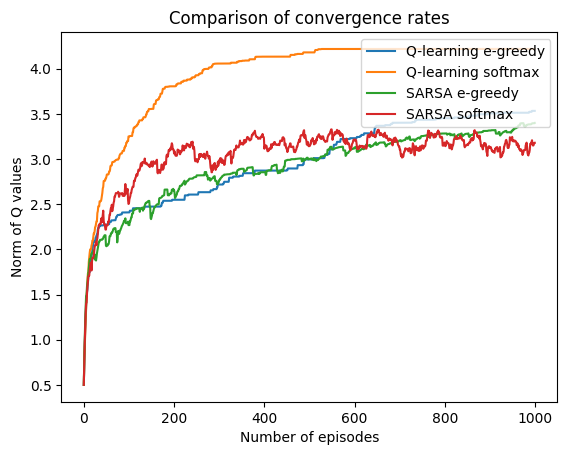

<Figure size 640x480 with 0 Axes>

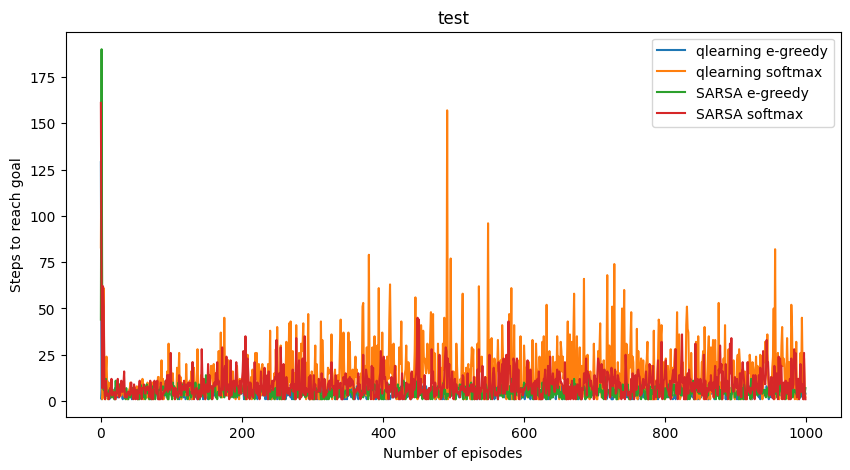

In [20]:
# example
plot_ql_sarsa(
    env, learning_rate=0.5, epsilon=0.02, temperature=0.16, nb_episodes=1000, render=False
)

# TO BE NOTED

We observe that when we apply the $\epsilon$-greedy method either on Q-Learning or SARSA approach, there is a quick stabilization with fewer steps (meaning that they converge fatser).

On the other hand, on the softmax approach, SARSA and Q-Learning seem to have much greater variance in step count, while we have more exploration and as a result a slower convergence.

More particularly, we observe that Q-learning softmax takes longer to stabilize. This is expected as softmax explores more broadly while delaying an optimal policy selection. However, SARSA updates the Q values based on the policy it follows. This makes it more stable but slower as it adapts to the current policy.

In conclusion $\epsilon$-greedy is simple and converges quickly but may not explore enough if $\epsilon$ is too low. On the contrary, softmax provides more structured exploration, leading to better Q-value estimation but requiring careful tuning of the temperature parameter beta.

### Effect of hyper-parameters

The other two hyper-parameters of **Q-learning** and **SARSA** are $\alpha$,
and $\gamma$. By varying the values of these hyper-parameters and watching the
learning process and behavior of the agent, explain their impact on the
algorithm. Using additional plotting functions is also welcome.

A good idea to visualize the effect of two parameters is to generate a heat map
by letting both parameters take values in a well-chosen interval.
Make sure that your figure complies with [The figure checklist](https://master-dac.isir.upmc.fr/The_figure_checklist.pdf).

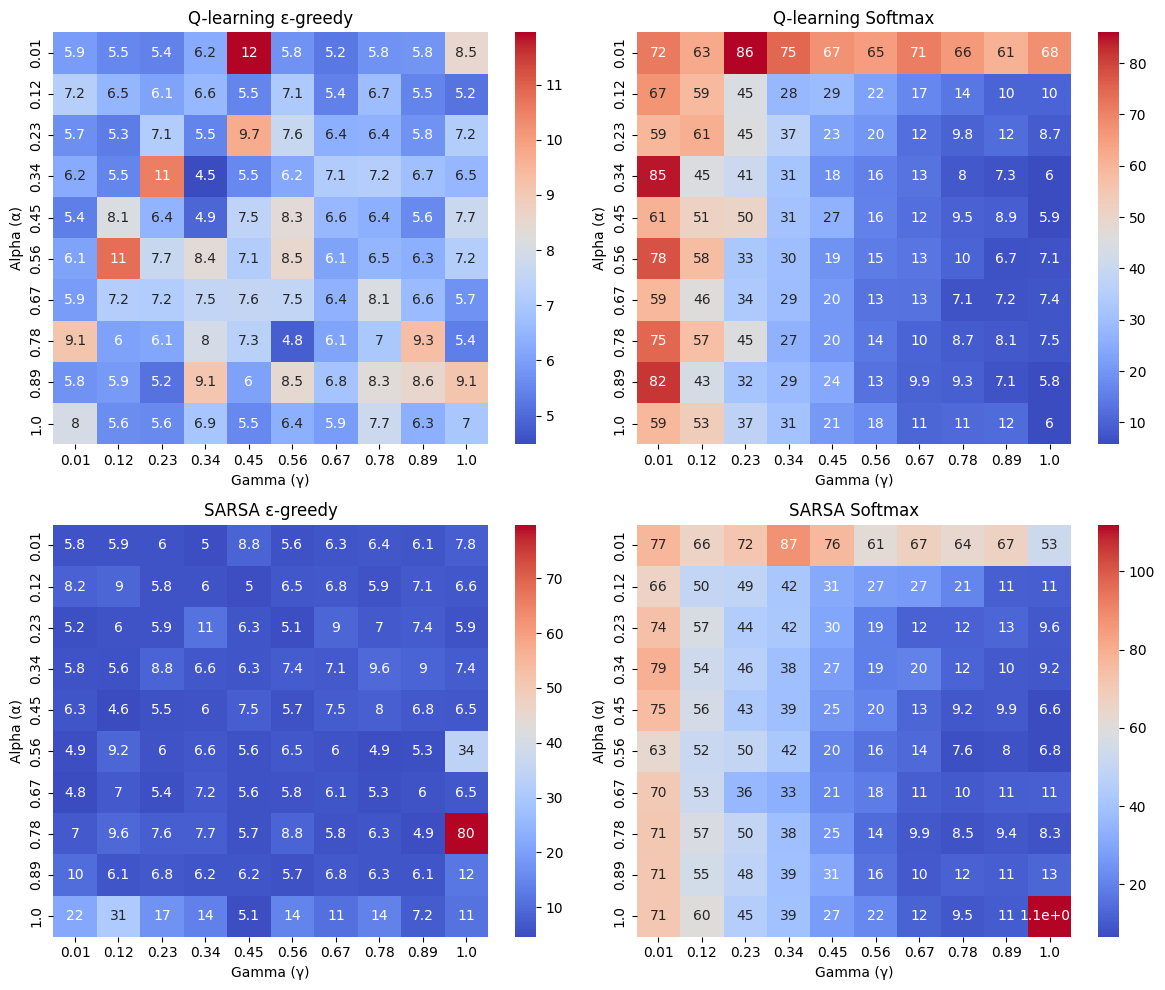

In [21]:
# Put your visualization code here

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Different alpha and gamma values
alpha_values = np.linspace(0.01, 1.0, 10)
gamma_values = np.linspace(0.01, 1.0, 10)

# Where the data are saved
performance_q_eps = np.zeros((len(alpha_values), len(gamma_values)))
performance_q_soft = np.zeros((len(alpha_values), len(gamma_values)))
performance_sarsa_eps = np.zeros((len(alpha_values), len(gamma_values)))
performance_sarsa_soft = np.zeros((len(alpha_values), len(gamma_values)))

# Simulation
for i, alpha1 in enumerate(alpha_values):
    for j, gamma in enumerate(gamma_values):
        env.gamma = gamma
        q_list1, time_list1 = q_learning_eps(env,alpha = alpha1, epsilon=0.02, nb_episodes=100, render=False)
        performance_q_eps[i, j] = np.mean(time_list1)
        q_list2, time_list2 = q_learning_soft(env, alpha = alpha1, beta=0.16, nb_episodes=100, render=False)
        performance_q_soft[i, j] = np.mean(time_list2)
        q_list3, time_list3 = sarsa_eps(env,alpha = alpha1, epsilon=0.02,nb_episodes=100, render=False)
        performance_sarsa_eps[i, j] = np.mean(time_list3)
        q_list4, time_list4 = sarsa_soft(env, alpha = alpha1,beta=0.16, nb_episodes=100, render=False)
        performance_sarsa_soft[i, j] = np.mean(time_list4)

# Grid ofr the 4 heatmaps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Heatmap Q-learning ε-greedy
sns.heatmap(performance_q_eps, xticklabels=np.round(gamma_values, 2), yticklabels=np.round(alpha_values, 2), cmap="coolwarm", annot=True, ax=axes[0, 0])
axes[0, 0].set_title("Q-learning ε-greedy")
axes[0, 0].set_xlabel("Gamma (γ)")
axes[0, 0].set_ylabel("Alpha (α)")

# Heatmap Q-learning Softmax
sns.heatmap(performance_q_soft, xticklabels=np.round(gamma_values, 2), yticklabels=np.round(alpha_values, 2), cmap="coolwarm", annot=True, ax=axes[0, 1])
axes[0, 1].set_title("Q-learning Softmax")
axes[0, 1].set_xlabel("Gamma (γ)")
axes[0, 1].set_ylabel("Alpha (α)")

# Heatmap SARSA ε-greedy
sns.heatmap(performance_sarsa_eps, xticklabels=np.round(gamma_values, 2), yticklabels=np.round(alpha_values, 2), cmap="coolwarm", annot=True, ax=axes[1, 0])
axes[1, 0].set_title("SARSA ε-greedy")
axes[1, 0].set_xlabel("Gamma (γ)")
axes[1, 0].set_ylabel("Alpha (α)")

# Heatmap SARSA Softmax
sns.heatmap(performance_sarsa_soft, xticklabels=np.round(gamma_values, 2), yticklabels=np.round(alpha_values, 2), cmap="coolwarm", annot=True, ax=axes[1, 1])
axes[1, 1].set_title("SARSA Softmax")
axes[1, 1].set_xlabel("Gamma (γ)")
axes[1, 1].set_ylabel("Alpha (α)")

# Ajuster l'affichage
plt.tight_layout()
plt.show()

# TO BE NOTED

On those heatmaps illustrate how the learning rate α and discount factor γ will affect either Q-learning or SARSA algorithms. Here we are proposing to test ε-greedy and softmax methods for different values of α and γ. Then we save the results in designated matrixes and we produce a heatmap as requested.

First of all, Q-learning is an off-policy method, and it tends to show more variability in its values, while SARSA on the other hand is an on-policy method, where we observe much more smoother transitions. As we have already seen ε-greedy strategy indicates a more aggressive exploration, whereas Softmax leads to more structured value distributions, particularly at low γ.

We observe that a higher α allows faster learning but it can cause instability, while a lower α ensures smoother learning but at the cost of slower convergence as expedted. Now whe we have a higher γ (discount factor) the agent prioritizes long terms rewards instead of short terms, whereas a low γ makes the agent prioritize immediate rewards, that can lead to more fluctuations.

In conclusion, Q-learning with softmax is sensitive to γ, with small values resulting in larger Q values, while SARSA with softmax demonstrates more stable and gradual changes. Lower α values stabilize learning, but they may require more iterations to reach optimal performance. Last but not least, choosing the right combination of α and γ depends on whether the goal is rapid learning with high variance or a steadier and more deliberate learning process.